
# 1st iteration: our dummy model

In [ ]:
import pandas as pd
titanic = pd.read_csv('https://raw.githubusercontent.com/JoanClaverol/titanic_data/main/train.csv')
# get info about the dataframe
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# get the top rows
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data quality check

### Missing values

In [ ]:
# check missing values
titanic.isna().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
titanic.shape

(891, 12)

### Duplicated rows

In [ ]:
# check duplicated rows
titanic.duplicated().sum()

0

## Basic exploration

In [ ]:
# Explore the number of people that has survived to the event. 
# Does it have any relation with any other variable on the dataset?
titanic.groupby(['Sex','Survived']).agg(count = ('Survived','count'))

count
Sex    Survived       
female 0            81
       1           233
male   0           468
       1           109

## Create our dummy model ("Train")

In [ ]:
# create a function to classify if a passanger has survied or not 
# based on another variable from our data
def my_dummy_model(sex): 
  if sex == 'female':
    return 1
  elif sex == 'male':
    return 0

In [ ]:
# let's add our prediction to our data
titanic['preds'] = [my_dummy_model(sex) for sex in titanic['Sex']]
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,preds
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


## Evaluate my model

Let's take a look at the two columns we want to compare:

In [ ]:
# add both columns on our data
error_check = (
titanic
  .filter(['Survived','preds'])
  .assign(check = lambda x: x['Survived'] == x['preds'])
)
error_check.sample(10)

,Survived,preds,check
254,0,1,False
292,0,0,True
191,0,0,True
277,0,0,True
106,1,1,True
113,0,1,False
568,0,0,True
247,1,1,True
843,0,0,True
330,1,1,True


In [ ]:
# check total number of correct answers
error_check['check'].sum()

701

In [ ]:
# calculate the accuracy of our model is: 
error_check['check'].sum() / error_check.shape[0]

0.7867564534231201

In [ ]:
# remove the predictions from our original data
titanic.drop(columns=['preds'], inplace=True)

**WARNING**: We are following a wrong approach at creating this model, as we will have to split our data into a training and a testing. 

# 2nd iteration: creating train and test

## Split the dataset

In [ ]:
# Create a train and a test with sklearn
from sklearn.model_selection import train_test_split

X = titanic.drop(columns=['Survived'])
y = titanic.filter(['Survived'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=8)

## Short exploration

In [ ]:
# quick exploration to our train data.
(
X_train
    .assign(Survived = y_train)
    .groupby(['Sex','Survived'])
    .agg(count = ('Survived','count'))
    )

count
Sex    Survived       
female 0            59
       1           179
male   0           351
       1            79

**WARNING**: we should never look at the test data, as it will cause bias on our analysis.

Based on this quick analyisis, we can apply the same model as before. 

## Test our model

In [ ]:
# Let's predict if someone will have survived or not with my dummy model
X_train['preds'] = [my_dummy_model(sex) for sex in X_train['Sex']]


Finding the accuracy for our train and test set:

In [ ]:
# results train data
(
X_train
  .filter(['preds'])
  .assign(survived = y_train)
    .assign(check = lambda x: x['survived'] == x['preds'])['check']
    .sum()
 ) / len(y_train)

0.7934131736526946

In [ ]:
# results test data
acc_2nd = (
X_test
  .assign(preds = lambda x: [my_dummy_model(sex) for sex in x['Sex']])
  .filter(['preds'])
  .assign(survived = y_test)
  .assign(check = lambda x: x['survived'] == x['preds'])['check']
  .sum()
 ) / len(y_test)

acc_2nd

0.7668161434977578

In [ ]:
(
  X_train
    .assign(Survived = y_train)
    .groupby(['Survived'])
    .agg(count = ('Survived','count'))
)

,count
Survived,
0,410
1,258


In [ ]:
410 / (410 + 258)

0.6137724550898204

# 3rd iteration: our first scikit-learning model

Time to create our first model, a decision tree. We are going only to use the column *Sex* as a predictor:

In [ ]:
# create the train and the test using the data
X = titanic.filter(['Sex'])
y = titanic.filter(['Survived'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=8)

In [ ]:
X_train.sample(5)

,Sex
172,female
783,male
299,female
883,male
535,female


## Pre process your data

How to transform a categorical variable into a numeric variable?

### With `pandas`

In [ ]:
# get_dummies from pandas
pd.get_dummies(X_train).sample(5)

,Sex_female,Sex_male
690,0,1
743,0,1
361,0,1
454,0,1
679,0,1


### With `sklearn`

In [ ]:
# OneHotEncoder on sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train)

OneHotEncoder(drop='first', sparse=False)

In [ ]:
# printing the category names
# as we know we have specified `drop='first'`, we are going only to keep
# the category male, which is in the 2nd positions of the array
ohe.get_feature_names_out()[0]

'Sex_male'

In [ ]:
# apply our transformer
X_train_enc = ohe.transform(X_train)
X_train_enc = pd.DataFrame(X_train_enc, columns=list(ohe.get_feature_names_out()))
X_train_enc.head()

,Sex_male
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


## Train our model

In [ ]:
# import and fit our decision tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train_enc, y_train)

DecisionTreeClassifier()

In [ ]:
X_train_enc.columns

Index(['Sex_male'], dtype='object')

### Visualise our model

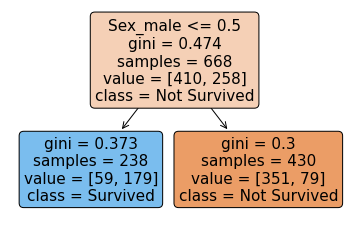

In [ ]:
# visualise our model
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plot_tree(
    tree, 
    filled = True, 
    rounded = True, 
    class_names = ['Not Survived', 'Survived'],
    feature_names=X_train_enc.columns
);

## Test our model

### Check the metrics on train

In [ ]:
# check the accuracy
from sklearn.metrics import accuracy_score

preds = tree.predict(X_train_enc)
accuracy_score(preds, y_train)
# 0.7934131736526946

0.7934131736526946

This is the same accuracy we got on the 2nd iteration, where we have created a dummy model with our own function (accuracy 2nd iteration was 0.7965653896961691)

### Metrics on test

In [ ]:
# 1st we need to transform our test set
X_test_enc = ohe.transform(X_test)
X_test_enc = pd.DataFrame(X_test_enc, columns=ohe.get_feature_names_out())

In [ ]:
# 2nd let's use our model to predict our values 
preds = tree.predict(X_test_enc)
acc_3rd = accuracy_score(preds, y_test)

#### Confusion matrix

Another way to visualise our errors is to use a confusion matrix:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


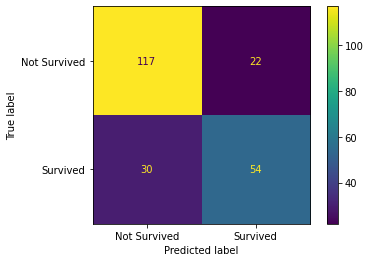

In [ ]:
# plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(tree, X_test_enc, y_test, display_labels=['Not Survived','Survived'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


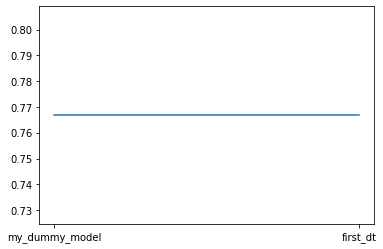

In [ ]:
iteration = ['my_dummy_model', 'first_dt']
accuracy = [acc_2nd, acc_3rd]

import seaborn as sns

sns.lineplot(iteration, accuracy)

Observations: 

* Total Not Survived: `65 + 18 = 83`. 
* Total Survived: `18 + 33 = 51`. 
* Not Survived correctly classified: `65` (`65 / 83 = 0.78` -> 78% over the total not survived people). 
* Survived correclty classified: `33` (`33 / 51 = 0.65` -> 65% over the total survived people).

# 4th iteration: more features + missing values preprocessing

Our goal is to use the power of decision trees to train our model with more variables. Now that we know how to introduce categorical variables into it, let's add more information in our model:

## Feature selection 

Let's decide which variables we think are important to predict if someone has survived or not to this disaster:

In [ ]:
titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
144,145,0,2,"Andrew, Mr. Edgardo Samuel",male,18.0,0,0,231945,11.5000,NaN,S
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C
681,682,1,1,"Hassab, Mr. Hammad",male,27.0,0,0,PC 17572,76.7292,D49,C
569,570,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C


In [ ]:
# train and test creation
X = titanic.drop(columns=['Name','Ticket','Cabin','PassengerId','Survived'])
y = titanic.filter(['Survived'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [ ]:
X_train['Age'].median()

29.0

In [ ]:
X_test['Age'].median()

25.5

## Preprocess

### Missing values

In [ ]:
# check missing values
X_train.isna().sum()

Pclass        0
Sex           0
Age         142
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 768 to 451
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    object 
 2   Age       570 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  710 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 44.5+ KB


#### Age missing values

Define numerical variables: 
* Age : Age in years
* SibSp : # of siblings / spouses aboard the Titanic
* Parch : # of parents / children aboard the Titanic
* Fare : Passenger fare

In [ ]:
# define a list of numeric columns
num_col = ['Age','Fare','SibSp','Parch']
X_train[num_col].head(10)

,Age,Fare,SibSp,Parch
768,NaN,24.1500,1,0
387,36.0,13.0000,0,0
823,27.0,12.4750,0,1
778,NaN,7.7375,0,0
157,30.0,8.0500,0,0
661,40.0,7.2250,0,0
392,28.0,7.9250,2,0
57,28.5,7.2292,0,0
863,NaN,69.5500,8,2
250,NaN,7.2500,0,0


In [ ]:
# import the missing values imputer from sklearn
from sklearn.impute import SimpleImputer

# define missing values imputer strategy
imp_num = SimpleImputer(strategy='median')

In [ ]:
# apply the imputer
X_train[num_col] = imp_num.fit_transform(X_train[num_col])
X_test[num_col] = imp_num.transform(X_test[num_col])

X_train.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

#### Embarked missing values


Categorical variables: 

* Pclass : 	Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
* Sex
* Embarked : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [ ]:
# impute missing values for categorical columns
cat_col = ['Pclass','Sex','Embarked']

imp_cat = SimpleImputer(strategy='most_frequent')

X_train[cat_col] = imp_cat.fit_transform(X_train[cat_col])
X_test[cat_col] = imp_cat.transform(X_test[cat_col])
X_train.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Encoding variables

In [ ]:
# encode variables with the once hot encoder
enc = OneHotEncoder(
    drop='first',
    sparse=False
)
X_train_enc = enc.fit_transform(X_train[cat_col])
X_test_enc = enc.transform(X_test[cat_col])

# apply the encoder to train
X_train_enc = pd.DataFrame(
    X_train_enc, 
    columns=enc.get_feature_names_out(), 
    index=X_train.index
)

X_train = pd.concat([X_train[num_col], X_train_enc], axis=1, ignore_index=False)

In [ ]:
# apply the encoder to test
X_test_enc = pd.DataFrame(
    X_test_enc, 
    columns=enc.get_feature_names_out(), 
    index=X_test.index
)

X_test = pd.concat([X_test[num_col], X_test_enc], axis=1, ignore_index=False)

,Age,Fare,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
350,23.0,9.2250,0.0,0.0,0.0,1.0,1.0,0.0,1.0
176,29.0,25.4667,3.0,1.0,0.0,1.0,1.0,0.0,1.0
723,50.0,13.0000,0.0,0.0,1.0,0.0,1.0,0.0,1.0
404,20.0,8.6625,0.0,0.0,0.0,1.0,0.0,0.0,1.0
306,29.0,110.8833,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
283,19.0,8.0500,0.0,0.0,0.0,1.0,1.0,0.0,1.0
715,19.0,7.6500,0.0,0.0,0.0,1.0,1.0,0.0,1.0
650,29.0,7.8958,0.0,0.0,0.0,1.0,1.0,0.0,1.0
808,39.0,13.0000,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## Training model

In [ ]:
# fit our model
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

### Plot our tree

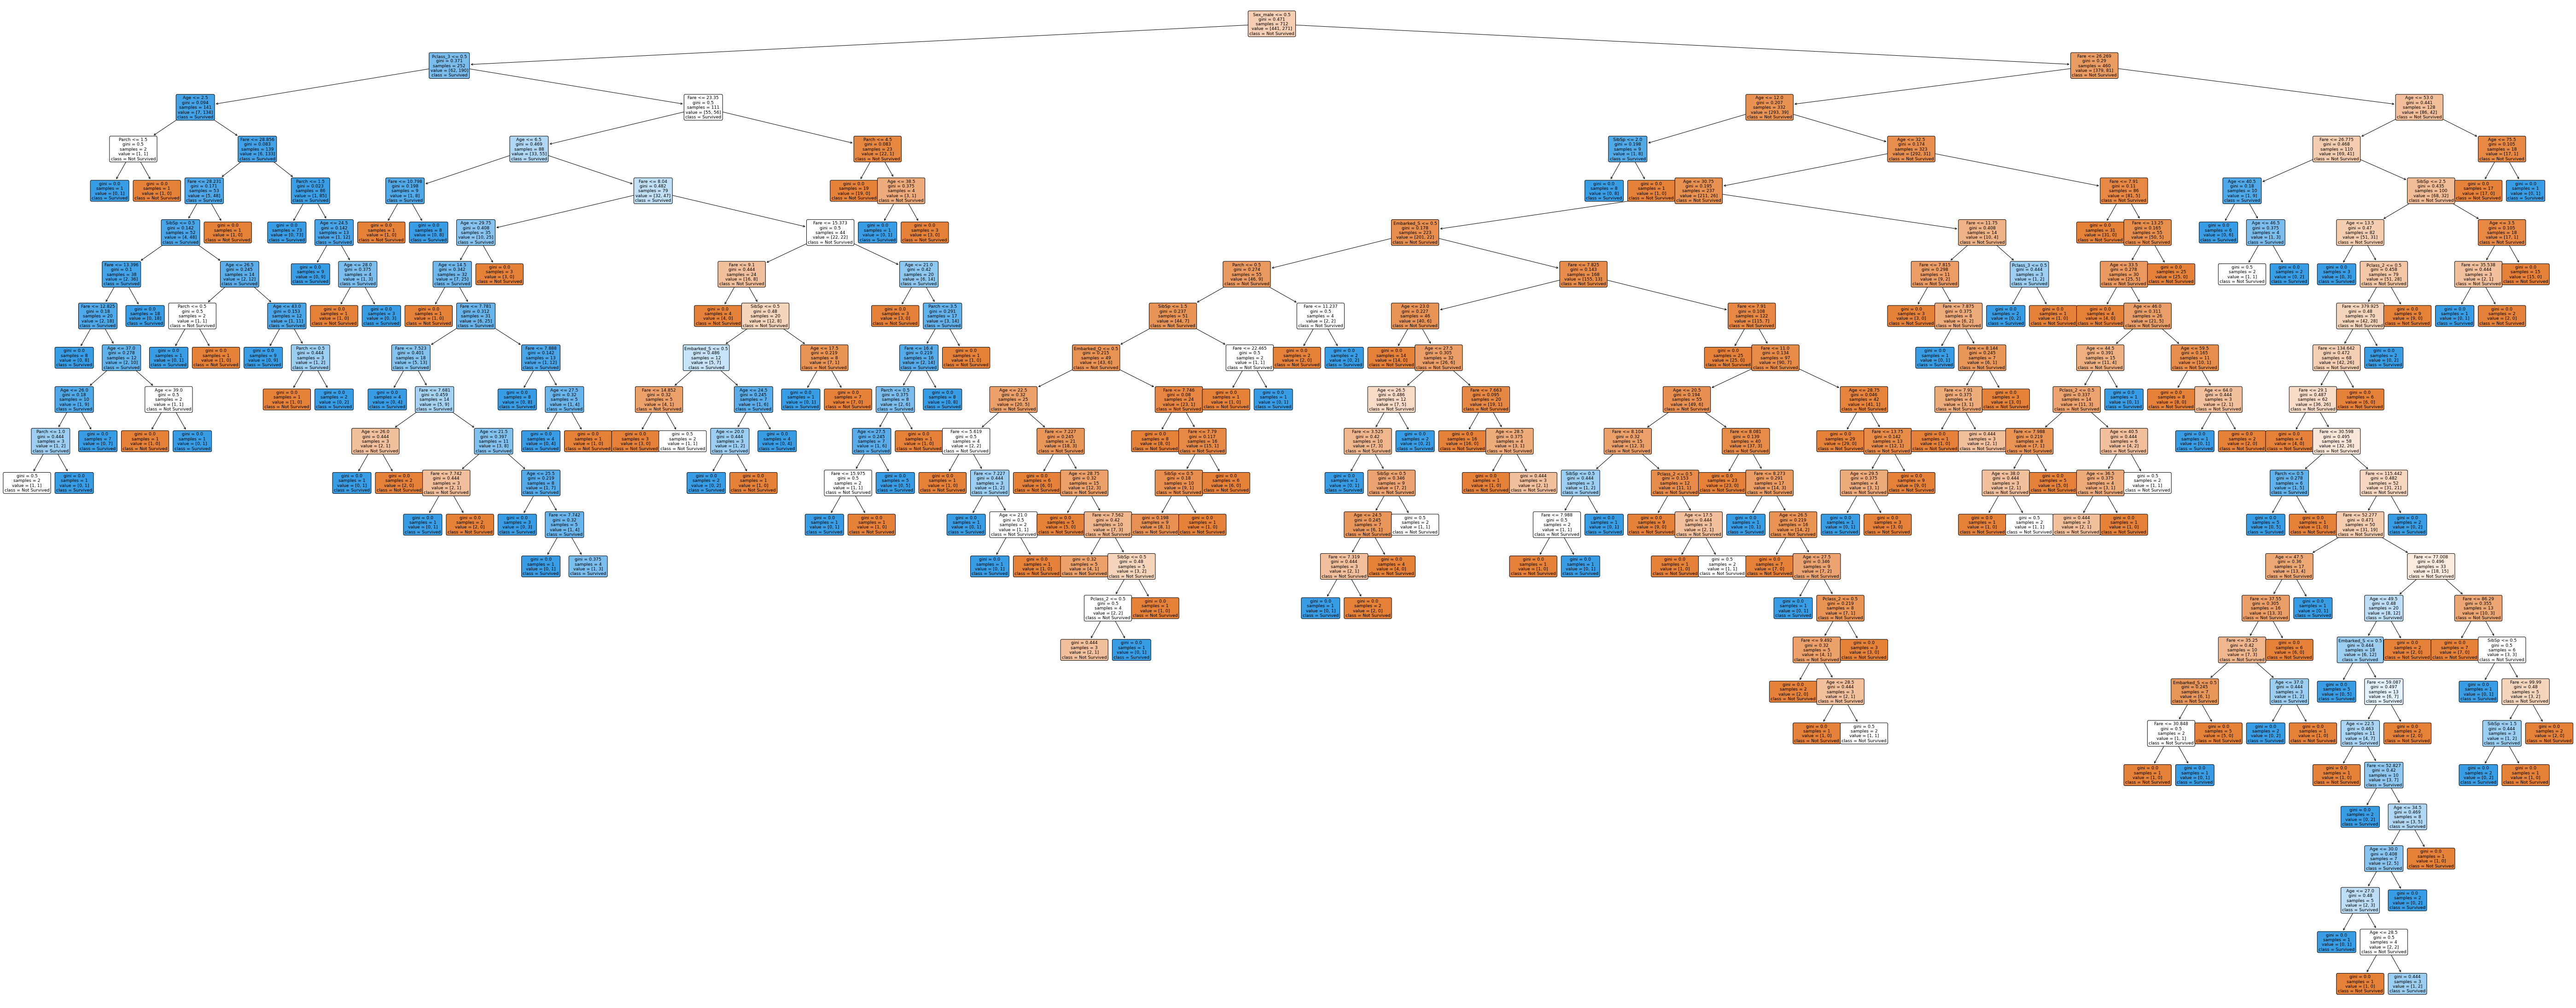

In [ ]:
# plot our tree
plt.figure(figsize=(100, 40))
plot_tree(
    tree,
    filled=True, 
    rounded=True, 
    class_names=['Not Survived', 'Survived'], 
    feature_names=X_train.columns
    );

## Test our model

In [ ]:
# accuracy in train set
preds = tree.predict(X_train)
accuracy_score(preds, y_train)

0.9775280898876404

In [ ]:
# accuracy in test set
preds = tree.predict(X_test)
accuracy_score(preds, y_test)

0.7653631284916201

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


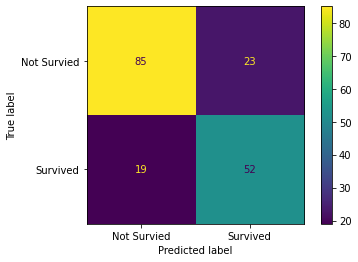

In [ ]:
# plot confusion matrix
plot_confusion_matrix(tree, X_test, y_test, display_labels=['Not Survied', 'Survived']);

# 5th iteration: prunning the tree

## Train our model with a max depth of 3

In [ ]:
# train a decision tree with maximum depth 3
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# plt.figure(figsize=(100, 40))
# plot_tree(
#     tree,
#     filled=True, 
#     rounded=True, 
#     class_names=['Not Survived', 'Survived'], 
#     feature_names=X_train.columns
#     );

DecisionTreeClassifier()

## Test our model

In [ ]:
# accuracy in train set
preds = tree.predict(X_train)
accuracy_score(preds, y_train)

0.8595505617977528

In [ ]:
# accuracy in test set
preds = tree.predict(X_test)
accuracy_score(preds, y_test)

0.7932960893854749

In [ ]:
pd.DataFrame({
    'importance':tree.feature_importances_, 
    'columns':X_train.columns
}).sort_values(by='importance', ascending=False)

,importance,columns
6,0.343936,Sex_male
1,0.256457,Fare
0,0.217451,Age
5,0.081623,Pclass_3
3,0.033042,Parch
2,0.029515,SibSp
8,0.014784,Embarked_S
4,0.013870,Pclass_2
7,0.009322,Embarked_Q
